In [1]:
import random
from collections import deque
import numpy as np
import gym
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline

from utils.replay_buffer import ReplayBuffer

In [2]:
class Actor(tf.keras.Model):
    def __init__(self, output_dim=1, hidden=32, name="actor", **kwargs):
        super().__init__(self, name=name, **kwargs)
        self.bn = tf.keras.layers.BatchNormalization(axis=-1)
        self.dense1 = tf.keras.layers.Dense(hidden, 
                                            activation="relu",
                                            use_bias=True,
                                            kernel_initializer="he_normal",
                                            bias_initializer="he_uniform"
                                            )
        self.dense2 = tf.keras.layers.Dense(hidden, 
                                            activation="relu",
                                            use_bias=True,
                                            kernel_initializer="he_normal",
                                            bias_initializer="he_uniform"
                                            )
        self.out = tf.keras.layers.Dense(output_dim, activation="tanh", use_bias=True)
    
    def call(self, inputs):
        x = self.bn(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.out(x)

class Critic(tf.keras.Model):
    def __init__(self, output_dim=1, hidden=32, name="critic", **kwargs):
        super().__init__(self, name=name, **kwargs)
        self.bn = tf.keras.layers.BatchNormalization(axis=-1)
        self.dense1 = tf.keras.layers.Dense(hidden, 
                                            activation="relu",
                                            use_bias=True,
                                            kernel_initializer="he_normal",
                                            bias_initializer="he_uniform"
                                            )
        self.dense2 = tf.keras.layers.Dense(hidden, 
                                            activation="relu",
                                            use_bias=True,
                                            kernel_initializer="he_normal",
                                            bias_initializer="he_uniform"
                                            )
        self.out = tf.keras.layers.Dense(output_dim, activation="linear", use_bias=True)
    
    def call(self, inputs):
        x = self.bn(tf.concat(inputs, axis=-1))
        x = self.dense1(x)
        x = self.dense2(x)
        return self.out(x) 

In [3]:
class DDPG:
    def __init__(self, 
                 env=None, 
                 hidden=32,
                 gamma=0.99,
                 tau=1e-3,
                 episodes=1000,
                 batch_size=32,
                 min_samples_start=320, 
                 actor_lr=1e-4,
                 critic_lr=2e-4,
                 seed=None
                 ):
        self.env = env

        self.actor = Actor(hidden=hidden, name="actor")
        self.critic = Critic(hidden=hidden, name="critic")
        self.actor_target = Actor(hidden=hidden, name="actor_target")
        self.critic_target = Critic(hidden=hidden, name="critic_target")
        self.critic_target.build(input_shape=(batch_size, 3))
        self.critic.build(input_shape=(batch_size, 3))
        self.actor_target.set_weights(self.actor.get_weights())
        self.critic_target.set_weights(self.critic.get_weights())

        self.gamma = gamma
        self.tau = tau

        self.episodes = episodes
        self.batch_size = batch_size
        self.min_samples_start = min_samples_start
        self.actor_opt = tf.keras.optimizers.Adam(learning_rate=actor_lr)
        self.critic_opt = tf.keras.optimizers.Adam(learning_rate=critic_lr)

        self.memo = ReplayBuffer(maxsize=100000)
        self.istraining = True
        if seed:
            tf.keras.backend.clear_session()
            self.env.seed(seed)
            random.seed(seed)
            np.random.seed(seed)
            tf.random.set_seed(seed)
        self.writer = tf.summary.create_file_writer("./recording/ddpg/")

    # @tf.function
    def training(self, states, actions, rewards, next_states, dones):
        next_actions = self.actor_target(next_states)
        next_Qs = self.critic_target([next_states, next_actions])
        target_Qs = tf.stop_gradient(rewards + self.gamma * next_Qs * (1. - dones))

        with tf.GradientTape() as tape:
            Qs = self.critic([states, actions])
            loss_c = tf.reduce_mean(tf.square(target_Qs - Qs))
        grads_c = tape.gradient(loss_c, self.critic.trainable_variables)
        self.critic_opt.apply_gradients(zip(grads_c, self.critic.trainable_variables))

        with tf.GradientTape() as tape:
            actions_ = self.actor(states)
            loss_a = -tf.reduce_mean(self.critic([states, actions_]))
        grads_a = tape.gradient(loss_a, self.actor.trainable_variables)
        self.actor_opt.apply_gradients(zip(grads_a, self.actor.trainable_variables))
        return loss_c.numpy(), loss_a.numpy()
    
    @tf.function
    def updates_target(self):
        actor_weights = self.actor.weights
        critic_weights = self.critic.weights
        actor_target_weights = self.actor_target.weights
        critic_target_weights = self.critic_target.weights

        for actor_weight, actor_target_weight in zip(actor_weights, actor_target_weights):
            actor_target_weight.assign(self.tau * actor_weight + (1. - self.tau) * actor_target_weight)
        
        for critic_weight, critic_target_weight in zip(critic_weights, critic_target_weights):
            critic_target_weight.assign(self.tau * critic_weight + (1. - self.tau) * critic_target_weight)

    def act(self, state):
        state = tf.cast(state[np.newaxis], dtype=tf.float32)
        action = self.actor(state) 
        if self.istraining:
            # TODO add OU noise
            noise = tf.random.uniform(action.shape, minval=-1., maxval=1., dtype=tf.float32)
            action += noise
        return np.squeeze(action, axis=0)

    def play_one_episode(self, env):
        state, done = env.reset(), False
        step_count, reward_sum = 0, 0
        while not done:
            action = self.act(state)
            next_state, reward, done, _ = env.step(action)
            self.memo.push(state.flatten(), action, reward, next_state.flatten(), done)
            state = next_state
            step_count += 1
            reward_sum += reward
            if self.istraining:  
                if len(self.memo) >= self.min_samples_start:
                    if len(self.memo) == self.min_samples_start:
                        print("Training start!")
                    samples = self.memo.get(self.batch_size)
                    loss = self.training(*samples)
                    self.updates_target()
        if len(self.memo) >= self.min_samples_start:
            return step_count, reward_sum, loss
        return step_count, reward_sum, None

    def play(self):
        self.steps_record = deque(maxlen=self.episodes)
        self.rewards_record = deque(maxlen=self.episodes)
        self.value_losses_record = deque(maxlen=self.episodes)
        self.policy_losses_record = deque(maxlen=self.episodes)

        for epi in range(1, self.episodes + 1):
            step_count, reward_sum, loss = self.play_one_episode(self.env)
            self.steps_record.append(step_count)
            self.rewards_record.append(reward_sum)
            if loss:
                self.value_losses_record.append(loss[0])
                self.policy_losses_record.append(loss[1])
                print(f"\rEpisode: {epi}, Total steps: {step_count}, Total reward: {reward_sum :.3f}, val_Loss: {loss[0] :.4f},  policy_Loss: {loss[1] :.4f}", end="")

                with self.writer.as_default():
                    tf.summary.scalar("steps", step_count, step=epi)
                    tf.summary.scalar("rewards", reward_sum, step=epi)
                    tf.summary.scalar("value_losses", loss[0], step=epi)
                    tf.summary.scalar("policy_losses", loss[1], step=epi)
                self.writer.flush()
        plt.plot(self.steps_record)
        plt.title("each episode steps")
        plt.show()
        plt.plot(self.rewards_record)
        plt.title("each episode reward")
        plt.show()
        plt.plot(self.value_losses_record)
        plt.title("each episode value loss")
        plt.show()
        plt.plot(self.policy_losses_record)
        plt.title("each episode policy loss")
        plt.show()

In [4]:
env = gym.make("MountainCarContinuous-v0")
# min_action = -1.0
# max_action = 1.0
# min_position = -1.2
# max_position = 0.6
# max_speed = 0.07

Training start!
Episode: 200, Total steps: 945, Total reward: 14.933, val_Loss: 0.1177,  policy_Loss: -10.0989

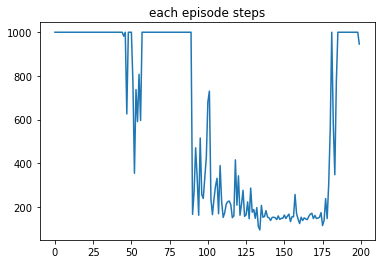

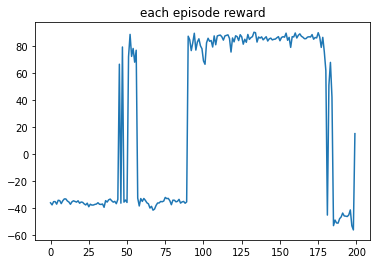

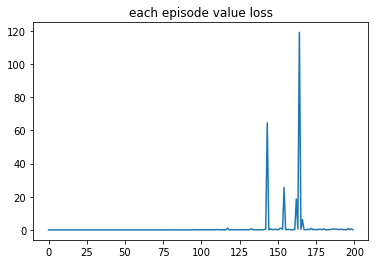

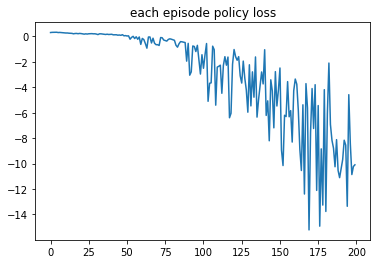

In [5]:
agent = DDPG(env=env, 
             hidden=32,
             gamma=0.99,
             tau=1e-3,
             episodes=200,
             batch_size=32, 
             min_samples_start=500,
             actor_lr=1e-4,
             critic_lr=5e-4,
             seed=42
             )
agent.play()